# Noise and Error Mitigitation in Quantum Real Circuits 
## Basado en el siguiente tutorial:
https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep8_Noise_and_Error_Mitigation.ipynb

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit.providers.ibmq import least_busy
#from qiskit.tools.monitor import job_monitor

In [3]:
from qiskit import *

In [4]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [5]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

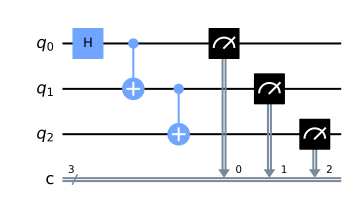

In [6]:
circuit.draw(output='mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()

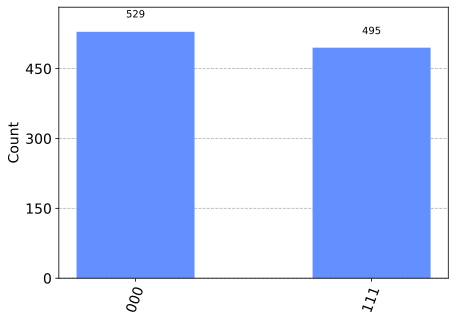

In [8]:
from qiskit.visualization import plot_histogram
plot_histogram(sim_result.get_counts(circuit))

In [9]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
provider = IBMQ.get_provider(hub='ibm-q-education', group='uni-antioquia-1', project='qc2021')
#Remote_QProcessor = provider.get_backend('ibm_perth')
#Remote_QSimulator = provider.get_backend('ibmq_qasm_simulator')

In [10]:
Remote_QProcessor = provider.get_backend('ibm_perth') # Maquina reservada temporalmente

In [11]:
#Remote_QProcessor = least_busy(provider.backends(filters=lambda qprocessor: qprocessor.configuration().n_qubits >= 2 
#                                       and not qprocessor.configuration().simulator 
#                                       and qprocessor.status().operational==True))
#print("El computador cuántico menos ocupado es el " + Remote_QProcessor.name())

In [12]:
# Definition of Calibration Circuits to mitigate the measurement error.

In [13]:
#from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.utils.mitigation import (complete_meas_cal, tensored_meas_cal,
                                        CompleteMeasFitter, TensoredMeasFitter)

In [14]:
calibration_circuits, quantum_states = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')

In [15]:
quantum_states

['000', '001', '010', '011', '100', '101', '110', '111']

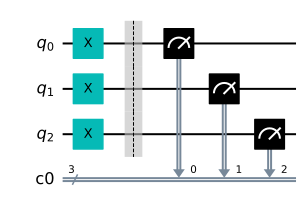

In [16]:
calibration_circuits[7].draw(output='mpl')

In [17]:
len(calibration_circuits)

8

In [18]:
cal_job = execute(calibration_circuits,
             backend=Remote_QProcessor,
             shots=8192,
             optimization_level=0)
print(cal_job.job_id())

63777867b95e16a1c5c27a67


In [19]:
#job_monitor(cal_job)

In [20]:
calibration_results = cal_job.result()

In [21]:
#job2=Remote_QProcessor.jobs()[0]
#cal_job2=Remote_QProcessor.retrieve_job('6332eaf75ccea74ca49477f9')
#cal_job2.status()

In [22]:
#calibration_results = cal_job2.result()

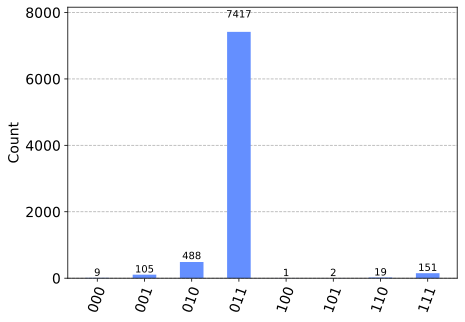

In [23]:
plot_histogram(calibration_results.get_counts(calibration_circuits[3]))

In [24]:
calibration_results.get_counts(calibration_circuits[3])

{'000': 9,
 '001': 105,
 '010': 488,
 '011': 7417,
 '100': 1,
 '101': 2,
 '110': 19,
 '111': 151}

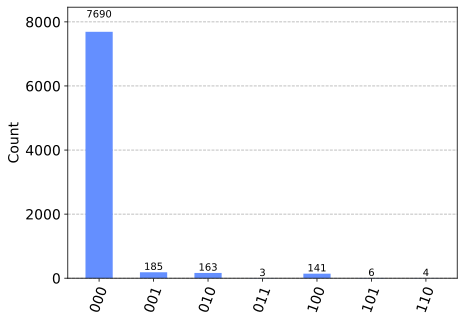

In [25]:
plot_histogram(calibration_results.get_counts(calibration_circuits[0]))

In [26]:
#for state in quantum_states:
#    qc = QuantumCircuit(3,3)
#    if state[0]=='1':
#        qc.x(1)
#    if state[1]=='1':
#        qc.x(0)  
#    qc.measure([0, 1], [0, 1])
#    t_qc = transpile(qc, aer_sim)
#    qobj = assemble(t_qc)
#    counts = aer_sim.run(qobj, noise_model=noise_model, shots=8192).result().get_counts()
    
#    calibration_results.get_counts(calibration_circuits[3])    
    
#print('000 becomes', calibration_results.get_counts(calibration_circuits[0]))
#print('001 becomes', calibration_results.get_counts(calibration_circuits[1]))
#print('010 becomes', calibration_results.get_counts(calibration_circuits[2]))
#print('011 becomes', calibration_results.get_counts(calibration_circuits[3]))
#print('100 becomes', calibration_results.get_counts(calibration_circuits[4]))
#print('101 becomes', calibration_results.get_counts(calibration_circuits[5]))
#print('110 becomes', calibration_results.get_counts(calibration_circuits[6]))
#print('111 becomes', calibration_results.get_counts(calibration_circuits[7]))

In [27]:
My_fitter = CompleteMeasFitter(calibration_results, quantum_states)

In [28]:
from qiskit.visualization import array_to_latex
array_to_latex(My_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [29]:
#My_fitter.plot_calibration()

In [30]:
Measurement_Filter = My_fitter.filter

# Running error mitigation on a second circuit

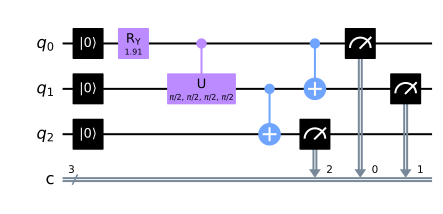

In [31]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit3 = QuantumCircuit(qreg_q, creg_c)

circuit3.reset(qreg_q[0])
circuit3.reset(qreg_q[1])
circuit3.reset(qreg_q[2])
circuit3.ry(1.9106332362490184, qreg_q[0])
circuit3.cu(pi / 2, pi / 2, pi / 2, pi / 2, qreg_q[0], qreg_q[1])
circuit3.cx(qreg_q[1], qreg_q[2])
circuit3.cx(qreg_q[0], qreg_q[1])
circuit3.measure(qreg_q[0], creg_c[0])
circuit3.measure(qreg_q[1], creg_c[1])
circuit3.measure(qreg_q[2], creg_c[2])

circuit3.draw(output='mpl')

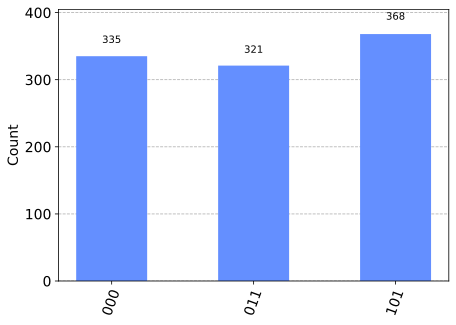

In [32]:
# Simulating the circuit and plotting the corresponding histogram:
Simulation_counts_2 = execute(circuit3, backend=simulator, shots=1024).result().get_counts(circuit3)
plot_histogram(Simulation_counts_2)

In [33]:
# Executing the circuit and plotting the corresponding histogram:
job2 = execute(circuit3, backend=Remote_QProcessor, shots=1024)
print(job2.job_id())
#job_monitor(job2)

6377789352d5020026486c53


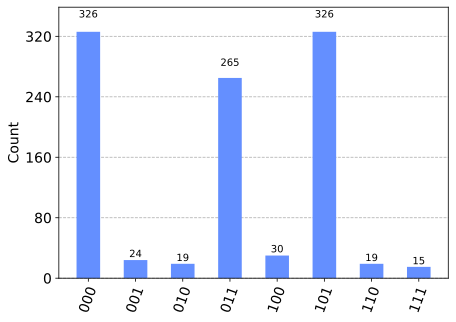

In [34]:
device_counts_2=job2.result().get_counts(circuit3)
plot_histogram(device_counts_2)

In [35]:
mitigated_counts_2 = Measurement_Filter.apply(device_counts_2)

In [36]:
#plot_histogram([device_counts_2, mitigated_counts_2], legend=['device, noisy','device, mitigated'])

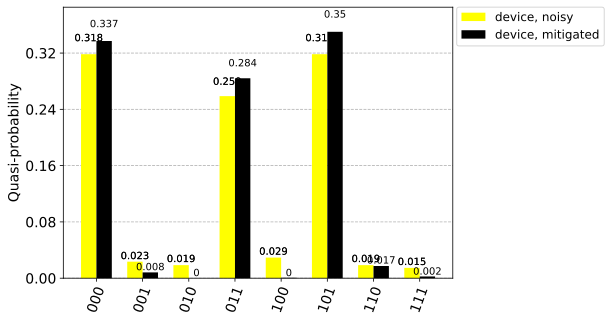

In [37]:
plot_histogram([device_counts_2, mitigated_counts_2], legend=['device, noisy','device, mitigated'],
               color=['yellow', 'black'], bar_labels=True)

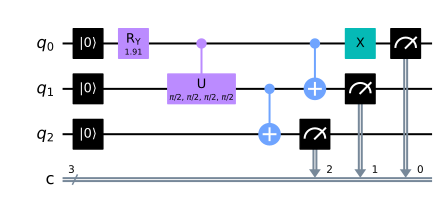

In [38]:
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit4 = QuantumCircuit(qreg_q, creg_c)

circuit4.reset(qreg_q[0])
circuit4.reset(qreg_q[1])
circuit4.reset(qreg_q[2])
circuit4.ry(1.9106332362490184, qreg_q[0])
circuit4.cu(pi / 2, pi / 2, pi / 2, pi / 2, qreg_q[0], qreg_q[1])
circuit4.cx(qreg_q[1], qreg_q[2])
circuit4.cx(qreg_q[0], qreg_q[1])
circuit4.x(qreg_q[0])
circuit4.measure(qreg_q[0], creg_c[0])
circuit4.measure(qreg_q[1], creg_c[1])
circuit4.measure(qreg_q[2], creg_c[2])

circuit4.draw(output='mpl')

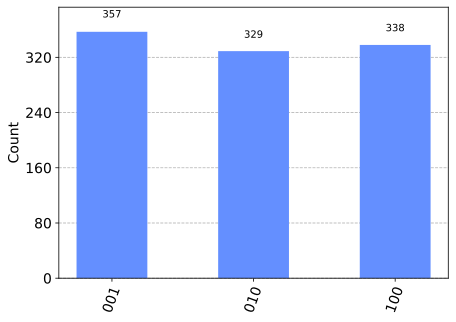

In [39]:
# Simulating the circuit and plotting the corresponding histogram:
Simulation_counts_3 = execute(circuit4, backend=simulator, shots=1024).result().get_counts(circuit4)
plot_histogram(Simulation_counts_3)

In [63]:
# Executing the circuit and plotting the corresponding histogram:
job3 = execute(circuit4, backend=Remote_QProcessor, shots=2048)
print(job3.job_id())

63777a378502e4461de89fce


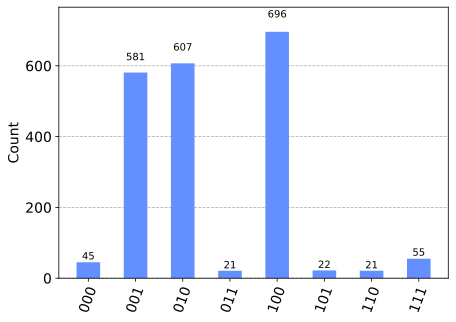

In [64]:
device_counts_3=job3.result().get_counts(circuit4)
plot_histogram(device_counts_3)

In [53]:
mitigated_counts_3 = Measurement_Filter.apply(device_counts_3)

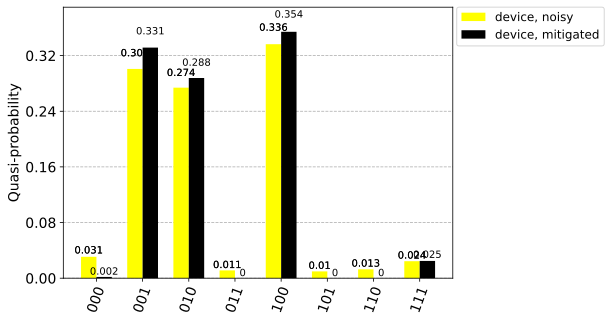

In [54]:
plot_histogram([device_counts_3, mitigated_counts_3], legend=['device, noisy','device, mitigated'],
               color=['yellow', 'black'], bar_labels=True)

In [44]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright